In [2]:
import sys
import gc
import numpy as np
import mmwave.dsp as dsp
import mmwave.clustering as clu
from mmwave.dataloader import DCA1000
from demo.visualizer.visualize import ellipse_visualize
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import scipy.signal as sp
from scipy.signal import chirp, spectrogram, butter, filtfilt, hilbert, correlate
from scipy.stats import linregress

In [3]:
numFrames = 384
numADCSamples = 256
numTxAntennas = 3
numRxAntennas = 4
numLoopsPerFrame = 16
numChirpsPerFrame = numTxAntennas * numLoopsPerFrame
numVirtAntennas = numTxAntennas * numRxAntennas

In [4]:
adc_data = np.fromfile("parser_scripts/adc_data.bin", dtype=np.uint16)
adc_data = adc_data.reshape(numFrames, -1)
adc_data = np.apply_along_axis(DCA1000.organize, 1, adc_data, num_chirps=numChirpsPerFrame,
                                num_rx=numRxAntennas, num_samples=numADCSamples)
print(f'adc_data shape: {adc_data.shape}')
# print("Data Loaded!")

adc_data shape: (384, 48, 4, 256)


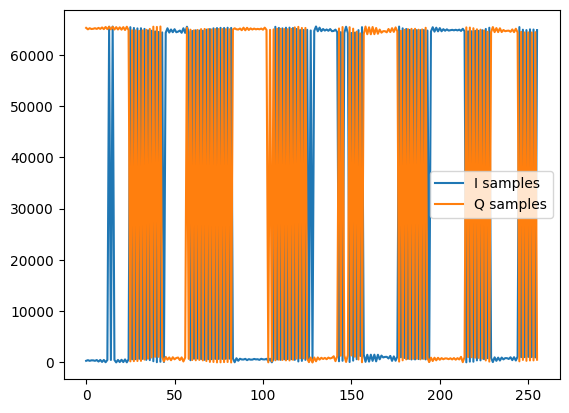

In [5]:
if_sig = adc_data[50][0][0] #50th frame, 1st Tx antenna, 1st chirp, 1st Rx antenna
plt.plot(np.real(if_sig), label='I samples')
plt.plot(np.imag(if_sig), label='Q samples')
plt.legend()

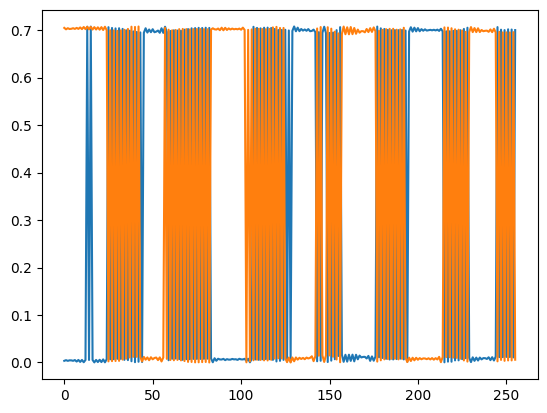

In [6]:
if_sig_normalised = if_sig/np.max(np.abs(if_sig))

plt.plot(np.real(if_sig_normalised))
plt.plot(np.imag(if_sig_normalised))

In [7]:
# Parameters 
f0 = 77e9 # 77 Ghz
S1 = 70e12 # Mhz / us 
S2 = 69.99e12 # Mhz / us 
fs = 5209 # ksps 
t_adc = 49.14e-6 #us
t_adc_valid = 7e-6 #us
t = np.linspace(0, t_adc + t_adc_valid, int(fs*1e3*(t_adc + t_adc_valid)))
print(len(t))
print(t)

# Template 
# phi_template = 2*np.pi*( S1*tau*t_rs + 0.5*(S1-Srx)*t_rs**2 + (f0*tau - 0.5*Srx*tau**2)) 

292
[0.00000000e+00 1.92920962e-07 3.85841924e-07 5.78762887e-07
 7.71683849e-07 9.64604811e-07 1.15752577e-06 1.35044674e-06
 1.54336770e-06 1.73628866e-06 1.92920962e-06 2.12213058e-06
 2.31505155e-06 2.50797251e-06 2.70089347e-06 2.89381443e-06
 3.08673540e-06 3.27965636e-06 3.47257732e-06 3.66549828e-06
 3.85841924e-06 4.05134021e-06 4.24426117e-06 4.43718213e-06
 4.63010309e-06 4.82302405e-06 5.01594502e-06 5.20886598e-06
 5.40178694e-06 5.59470790e-06 5.78762887e-06 5.98054983e-06
 6.17347079e-06 6.36639175e-06 6.55931271e-06 6.75223368e-06
 6.94515464e-06 7.13807560e-06 7.33099656e-06 7.52391753e-06
 7.71683849e-06 7.90975945e-06 8.10268041e-06 8.29560137e-06
 8.48852234e-06 8.68144330e-06 8.87436426e-06 9.06728522e-06
 9.26020619e-06 9.45312715e-06 9.64604811e-06 9.83896907e-06
 1.00318900e-05 1.02248110e-05 1.04177320e-05 1.06106529e-05
 1.08035739e-05 1.09964948e-05 1.11894158e-05 1.13823368e-05
 1.15752577e-05 1.17681787e-05 1.19610997e-05 1.21540206e-05
 1.23469416e-05 1.25

In [8]:
# Receiving signal with time differece
d = 105e-3 #m 
c = 3e8 # m/s
tau = d/c
print(tau)

3.5e-10


delta =  0


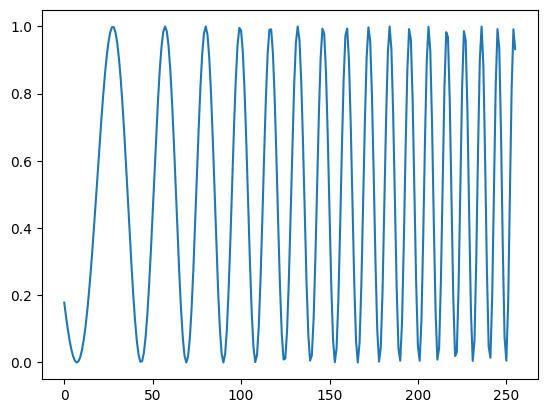

In [9]:
np.random.seed(41)
delta = 0 #np.random.rand()*2*np.pi  # Generate a random phase shift (due to lack of phase locking)
phi_template = 2*np.pi*( S2*tau*t + 0.5*(S1-S2)*t**2 + (f0*tau - 0.5*S2*tau**2) ) - delta
template_sig = 0.5*np.cos(phi_template) + 0.5
template_sig = template_sig[-256:]

print("delta = ", delta)
plt.plot(template_sig)


/home/sohamc1909/miniconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/sohamc1909/miniconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


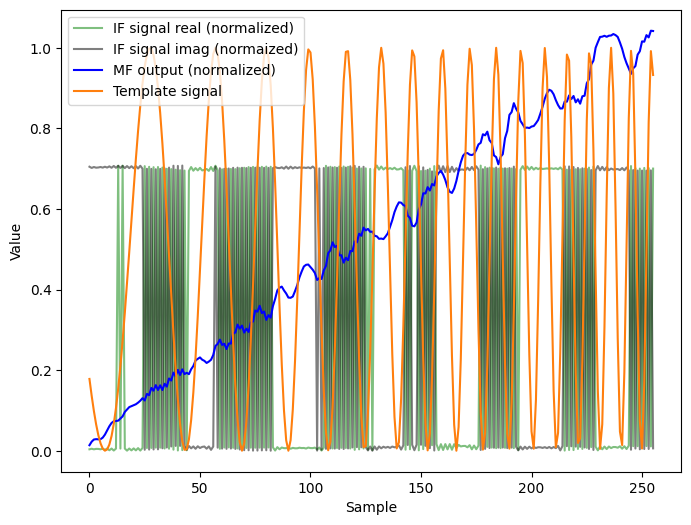

In [10]:
h_mf = np.conj(hilbert(template_sig)[::-1])
mf_output = sp.lfilter(h_mf, 1, if_sig_normalised)

plt.figure(figsize=(8,6))
plt.plot(np.real(if_sig_normalised), label='IF signal real (normalized)', c='green', alpha=0.5)
plt.plot(np.imag(if_sig_normalised), label='IF signal imag (normaized)', c='black',  alpha=0.5)
plt.plot(mf_output/np.max(mf_output), label='MF output (normalized)', c='blue')
plt.plot(template_sig, label='Template signal', c='tab:orange')
plt.legend(loc="upper left")
plt.xlabel("Sample")
plt.ylabel("Value")
plt.show()

/tmp/ipykernel_5801/2479035706.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  mf_output_hmap[idx] = sp.lfilter(h_mf, 1, if_sig_normalised)


<Axes: >

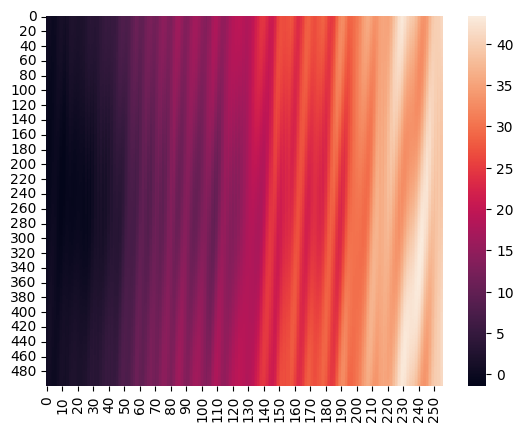

In [11]:
import seaborn as sns 
deltas = np.linspace(0, 2*np.pi, 500)  #Generate 500 test deltas to check 

mf_output_hmap = np.zeros((len(deltas), 256))
for idx, delta_x in enumerate(deltas):
    # Checking with templates with different delta
    phi_template = 2*np.pi*( S2*tau*t + 0.5*(S1-S2)*t**2 + (f0*tau - 0.5*S2*tau**2) ) - delta_x
    template_sig = 0.5*np.cos(phi_template) + 0.5
    template_sig = template_sig[-256:]
    h_mf = np.conj(hilbert(template_sig)[::-1])
    mf_output_hmap[idx] = sp.lfilter(h_mf, 1, if_sig_normalised)

sns.heatmap(mf_output_hmap)

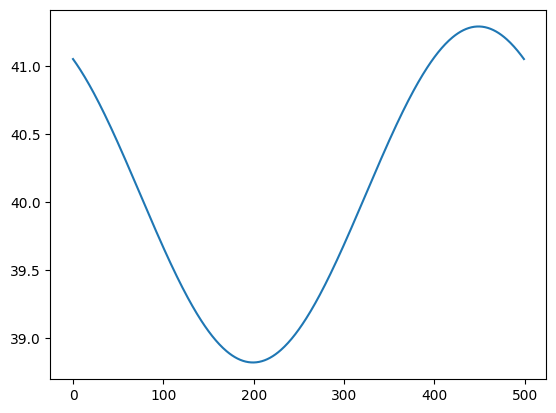

In [12]:
plt.plot(mf_output_hmap[:,-1])

In [14]:
# Compare with no back radar data 
numFrames_nb = 309
adc_data_nb = np.fromfile("parser_scripts/adc_data_no_radar.bin", dtype=np.uint16)
adc_data_nb = adc_data_nb.reshape(numFrames_nb, -1)
adc_data_nb = np.apply_along_axis(DCA1000.organize, 1, adc_data_nb, num_chirps=numChirpsPerFrame,
                                num_rx=numRxAntennas, num_samples=numADCSamples)
print(f'adc_data_nb shape: {adc_data_nb.shape}')

adc_data_nb shape: (309, 48, 4, 256)


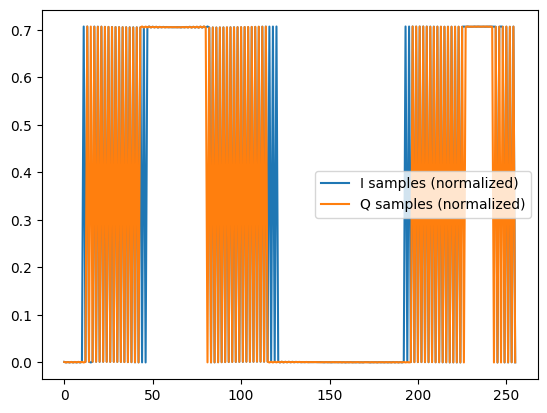

In [20]:
if_sig_nb = adc_data_nb[70][0][0]
if_sig_normalised_nb = if_sig_nb/np.max(np.abs(if_sig_nb))

plt.plot(np.real(if_sig_normalised_nb), label='I samples (normalized)')
plt.plot(np.imag(if_sig_normalised_nb), label='Q samples (normalized)')
plt.legend()
plt.show()

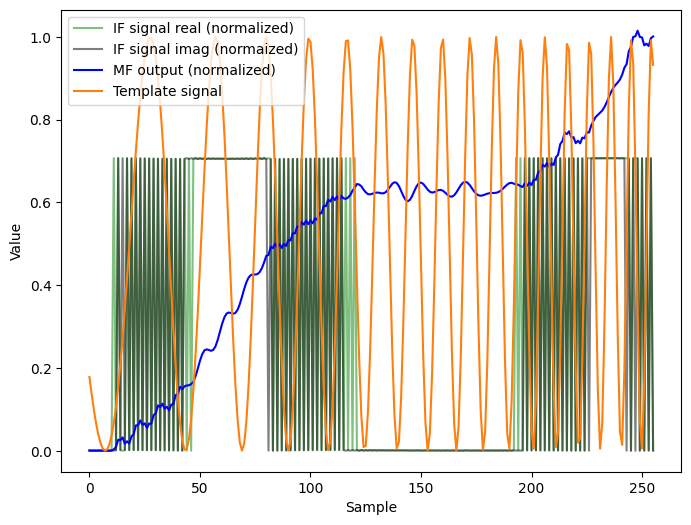

In [21]:
mf_output_nb = sp.lfilter(h_mf, 1, if_sig_normalised_nb)

plt.figure(figsize=(8,6))
plt.plot(np.real(if_sig_normalised_nb), label='IF signal real (normalized)', c='green', alpha=0.5)
plt.plot(np.imag(if_sig_normalised_nb), label='IF signal imag (normaized)', c='black',  alpha=0.5)
plt.plot(mf_output_nb/np.max(mf_output_nb), label='MF output (normalized)', c='blue')
plt.plot(template_sig, label='Template signal', c='tab:orange')
plt.legend(loc="upper left")
plt.xlabel("Sample")
plt.ylabel("Value")
plt.show()